In [1]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


/software/cellgen/team361/aa34/envs/disect/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from celldisect import CellDISECT
import rapids_singlecell as rsc
# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [3]:
adata = sc.read_h5ad('../eraslan_preprocessed1212_split_deg.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()

In [4]:
adata.layers['counts'].max()

3370.0

In [5]:
adata.X.max()

9.210441

In [6]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [7]:
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']
split_key = 'split_1'
cell_type_included = True # Set to True if you have provided a cell type annotation in the cats list
if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )
pre_path = '../models/ablation_celldisect_cfW_withCT/'
model_paths = []
for model_path in os.listdir(pre_path):
    model_paths.append(model_path)

In [8]:
model_paths = [p for p in model_paths if split_key in p]

In [9]:
model_paths

['celldisect_allones_withCT_cfW_2.5_split_split_1',
 'celldisect_allones_withCT_cfW_50.0_split_split_1',
 'celldisect_allones_withCT_cfW_9.0_split_split_1',
 'celldisect_allones_withCT_cfW_5.0_split_split_1',
 'celldisect_allones_withCT_cfW_3.0_split_split_1',
 'celldisect_allones_withCT_cfW_10.0_split_split_1',
 'celldisect_allones_withCT_cfW_4.0_split_split_1',
 'celldisect_allones_withCT_cfW_2.0_split_split_1',
 'celldisect_allones_withCT_cfW_0.8_split_split_1',
 'celldisect_allones_withCT_cfW_8.0_split_split_1',
 'celldisect_allones_withCT_cfW_6.0_split_split_1',
 'celldisect_allones_withCT_cfW_4.5_split_split_1',
 'celldisect_allones_withCT_cfW_7.0_split_split_1',
 'celldisect_allones_withCT_cfW_1.5_split_split_1',
 'celldisect_allones_withCT_cfW_20.0_split_split_1',
 'celldisect_allones_withCT_cfW_3.5_split_split_1']

In [10]:
names = [name.split('_')[-4] for name in model_paths]
names

['2.5',
 '50.0',
 '9.0',
 '5.0',
 '3.0',
 '10.0',
 '4.0',
 '2.0',
 '0.8',
 '8.0',
 '6.0',
 '4.5',
 '7.0',
 '1.5',
 '20.0',
 '3.5']

In [11]:
models = {}
for i, model_path in enumerate(model_paths):
    models[names[i]] = CellDISECT.load(f"{pre_path}/{model_path}", adata=adata)

INFO     File ../models/ablation_celldisect_cfW_withCT//celldisect_allones_withCT_cfW_2.5_split_split_1/model.pt   
         already downloaded                                                                                        


CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File ../models/ablation_celldisect_cfW_withCT//celldisect_allones_withCT_cfW_50.0_split_split_1/model.pt  
         already downloaded                                                                                        
INFO     File ../models/ablation_celldisect_cfW_withCT//celldisect_allones_withCT_cfW_9.0_split_split_1/model.pt   
         already downloaded                                                                                        
INFO     File ../models/ablation_celldisect_cfW_withCT//celldisect_allones_withCT_cfW_5.0_split_split_1/model.pt   
         already downloaded                                                                                        
INFO     File ../models/ablation_celldisect_cfW_withCT//celldisect_allones_withCT_cfW_3.0_split_split_1/model.pt   
         already downloaded                                                                                        
INFO     File ../models/ablation_celldisect_cfW_withCT//celldisect_allon

In [12]:
models = dict(sorted(models.items(), key=lambda t: float(t[0])))

In [13]:
n_samples_from_source_max = 500

In [14]:
cell_type_to_check = 'Immune (DC/macrophage)'


cov_names = ['sex']
cov_values = ['female']
cov_values_cf = ['male']

adata_ = adata[(adata.obs['Broad cell type'] == cell_type_to_check) &
                (adata.obs['tissue'] == 'lingula of left lung')].copy()

n_samples_from_source = min(n_samples_from_source_max, len(adata_[((adata_.obs['sex'] == 'female'))]))

In [15]:

#     cell_type_to_check = 'Epithelial cell (luminal)'
#     n_samples_from_source = min(n_samples_from_source_max, len(adata[(adata.obs['Broad cell type'] == cell_type_to_check) &
#                     (adata.obs['tissue'] == 'breast') & (adata.obs['sex'] == 'female')]))


#     cov_names = ['sex', 'tissue']
#     cov_values = ['female', 'breast']
#     cov_values_cf = ['male', 'prostate gland']

#     adata_ = adata[adata.obs['Broad cell type'] == cell_type_to_check].copy()

In [16]:
RANDOM_SEED = 42
preds = {}
for name, model in models.items():
    x_ctrl, x_true, x_pred = model.predict_counterfactuals(
                                            adata_.copy(),
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                            cats=cats,
                                            n_samples_from_source=n_samples_from_source,
                                            seed=RANDOM_SEED,
                                            )

    x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)
    preds[name] = x_pred

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer set

In [17]:
deg_list = adata.uns['rank_genes_groups_split_1']['Immune (DC']['macrophage)_male']
deg_list

array(['RP11-108E14.1', 'LINC00486', 'IFITM3', 'TXNRD1', 'EEF1A1', 'XIST',
       'BAIAP2L1', 'APOO', 'PFN1', 'XPO5', 'FAU', 'S100A4', 'OOEP',
       'TPT1', 'ACTG1', 'SH3BGRL3', 'UBA52', 'PLEKHA7', 'HLA-DPA1',
       'YBX1', 'COX4I1', 'ACTB', 'CST3', 'TMSB10', 'TMSB4X', 'GAPDH',
       'SLC2A3', 'F13A1', 'SPP1', 'S100A11', 'TIMP1', 'HLA-DQA1', 'TFRC',
       'MSR1', 'HLA-DPB1', 'FCER1G', 'B2M', 'S100A6', 'SERF2', 'CD163',
       'OLR1', 'HLA-DRA', 'RBPJ', 'CTSB', 'SLC1A3', 'SLC11A1', 'STAC',
       'TYROBP', 'VIM', 'C1QB', 'HERPUD1', 'GLUL', 'MRC1', 'HLA-DRB1',
       'C1QA', 'LYZ', 'PPARG', 'VCAN', 'RNF144B'], dtype=object)

In [18]:
from scipy.stats import wasserstein_distance

emd_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    emd_results[str(n_top_deg)] = {}
    for name, x_pred in preds.items():
        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]
        # for method_name, method in zip(['CellDISECT', 'Control'], [x_pred_deg, x_ctrl_deg]):
        wd = []
        for i in range(x_true_deg.shape[1]):
            wd.append(
                wasserstein_distance(torch.tensor(x_true_deg[:, i]), torch.tensor(x_pred_deg[:, i]))
            )
        emd_results[str(n_top_deg)][name] = np.mean(wd)

emd_results = pd.DataFrame.from_dict(emd_results).T
emd_results

,0.8,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0,20.0,50.0
20,0.322784,0.345257,0.331002,0.342685,0.344184,0.356841,0.347229,0.368041,0.344751,0.360061,0.317818,0.340724,0.339390,0.332639,0.342418,0.371730
all,0.095690,0.092965,0.097106,0.098298,0.097128,0.093975,0.096912,0.090018,0.097577,0.094301,0.102929,0.096603,0.101808,0.102243,0.090788,0.081489


In [19]:
r2_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    r2_results[str(n_top_deg)] = {}
    for name, x_pred in preds.items():
        
        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]

        r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))

        r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))

        r2_results[str(n_top_deg)][name] = r2_mean_deg[0]

        r2_results[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

r2_results = pd.DataFrame.from_dict(r2_results).T
r2_results

,0.8,0.8_var,1.5,1.5_var,2.0,2.0_var,2.5,2.5_var,3.0,3.0_var,...,8.0,8.0_var,9.0,9.0_var,10.0,10.0_var,20.0,20.0_var,50.0,50.0_var
20,0.645701,0.928073,0.671380,0.946367,0.663415,0.937957,0.689497,0.961143,0.685703,0.959122,...,0.693549,0.963821,0.700289,0.966994,0.699381,0.966120,0.696945,0.966076,0.697652,0.966335
all,0.546612,0.668715,0.429076,0.608877,0.467144,0.636099,0.309773,0.513171,0.343603,0.578765,...,0.272217,0.499426,0.171587,0.315430,0.267071,0.424633,0.152834,0.304552,0.135921,0.270935


In [20]:
r2_results_subtract = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    r2_results_subtract[str(n_top_deg)] = {}
    for name, x_pred in preds.items():

        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]
        x_ctrl_deg = x_ctrl[:, degs]


        r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

        r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

        r2_results_subtract[str(n_top_deg)][name] = r2_mean_deg[0]

        r2_results_subtract[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T
r2_results_subtract

,0.8,0.8_var,1.5,1.5_var,2.0,2.0_var,2.5,2.5_var,3.0,3.0_var,...,8.0,8.0_var,9.0,9.0_var,10.0,10.0_var,20.0,20.0_var,50.0,50.0_var
20,0.599515,0.947716,0.589152,0.952747,0.603158,0.947724,0.622095,0.951461,0.616286,0.952339,...,0.632476,0.951578,0.652080,0.951641,0.652610,0.950996,0.646787,0.948686,0.621809,0.949901
all,0.271235,0.035713,0.242799,0.031602,0.238261,0.021461,0.177700,0.012426,0.187780,0.019145,...,0.163543,0.016517,0.107295,0.006610,0.148868,0.009750,0.105186,0.002877,0.107947,0.002727


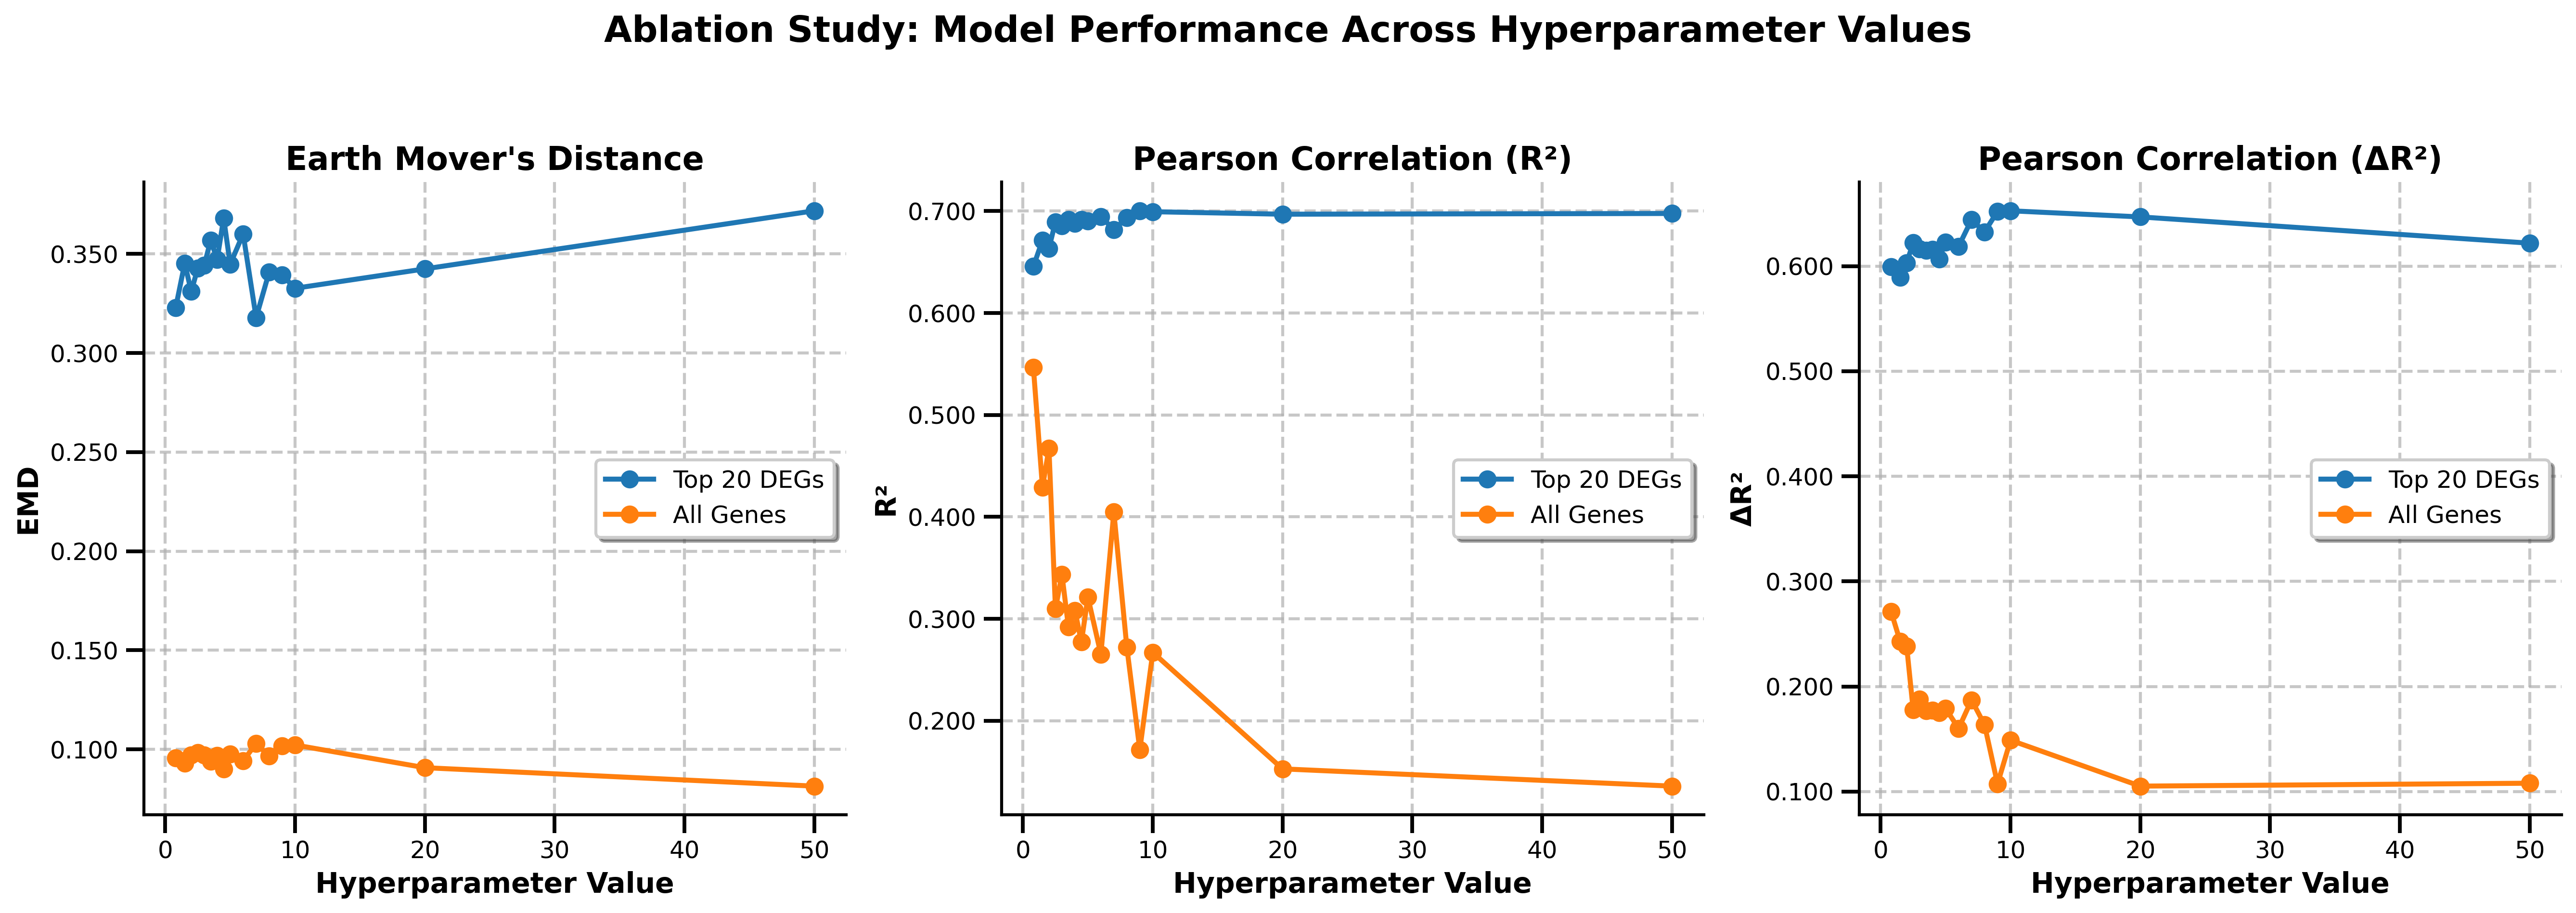

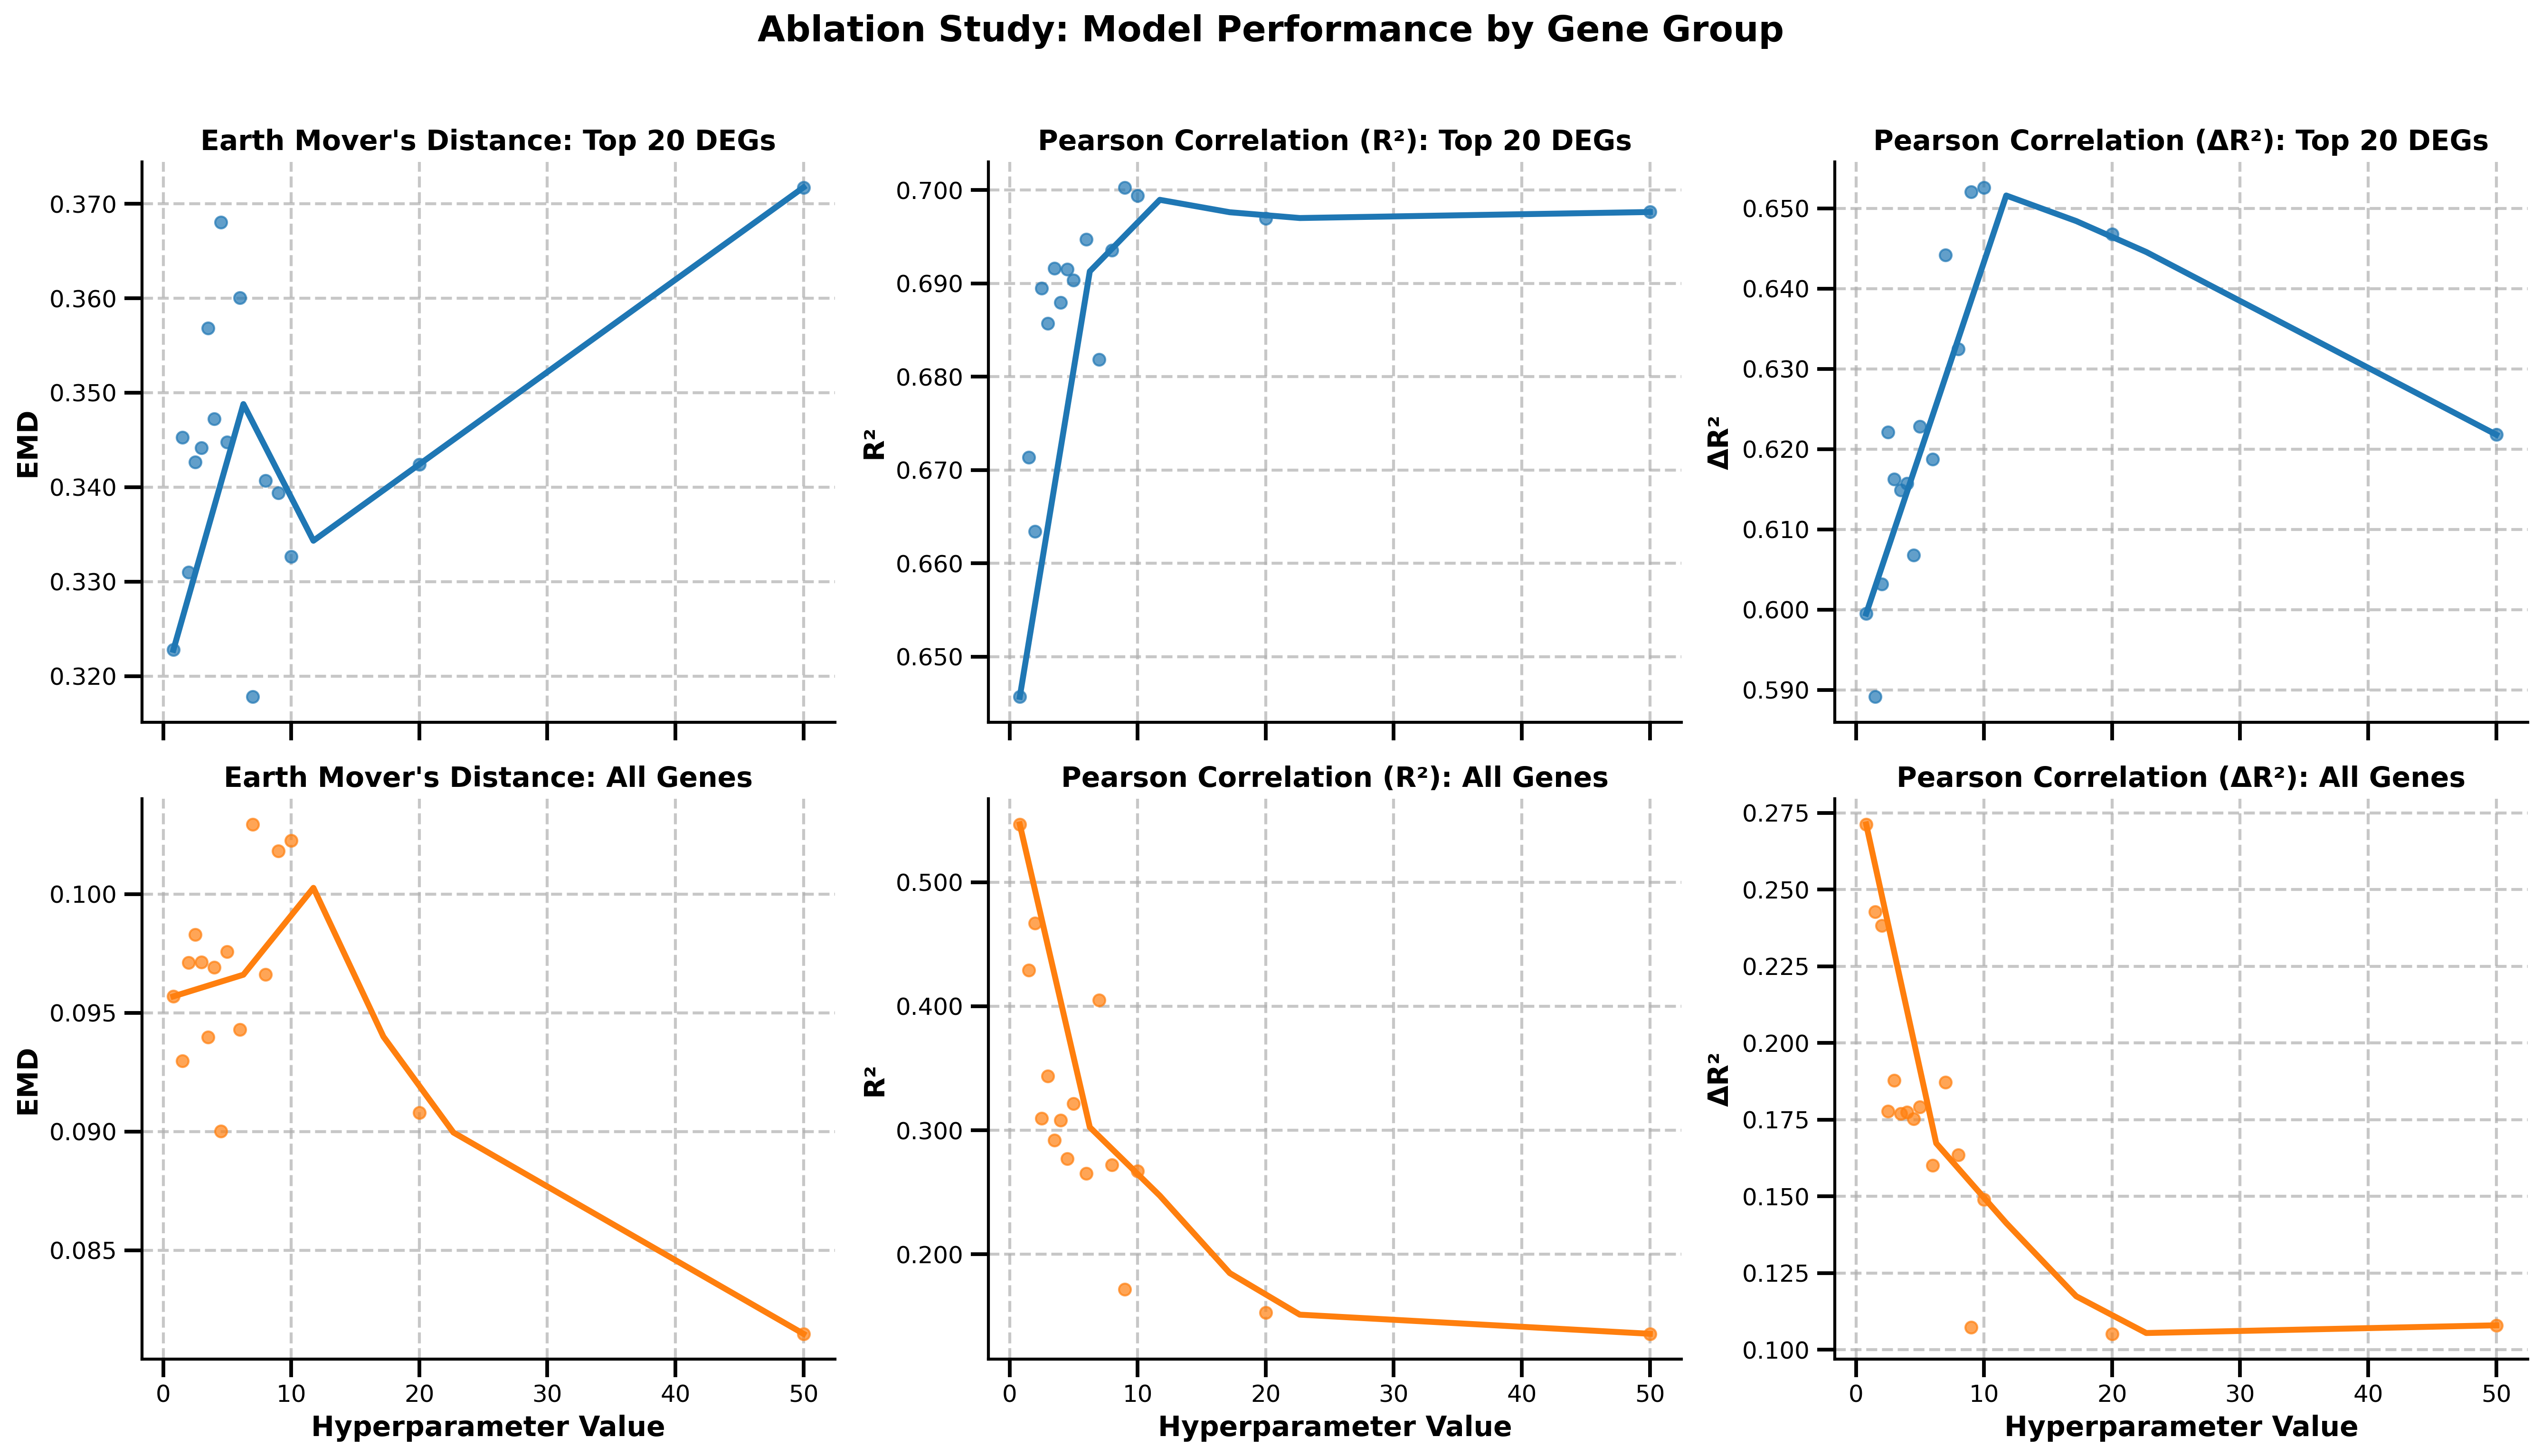

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()

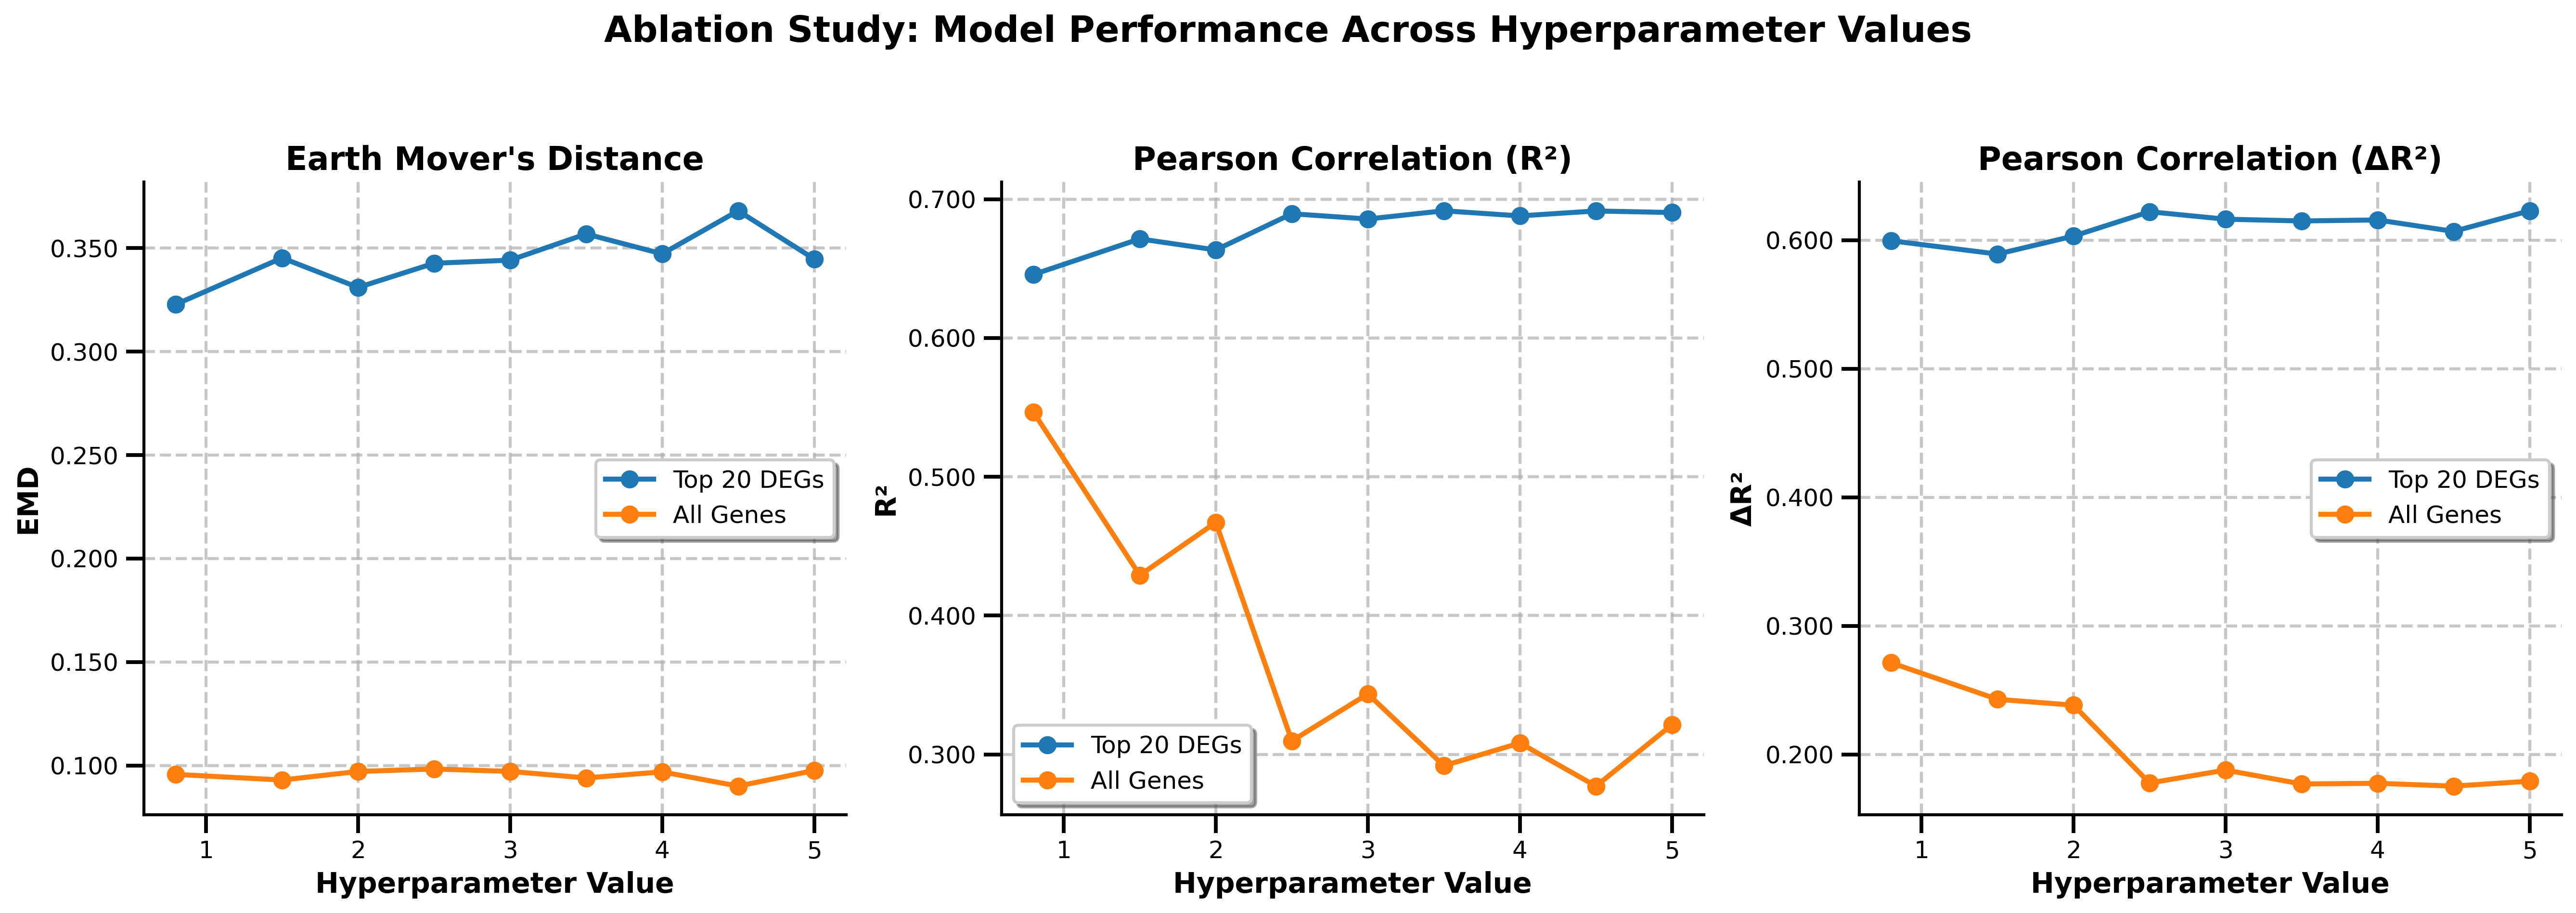

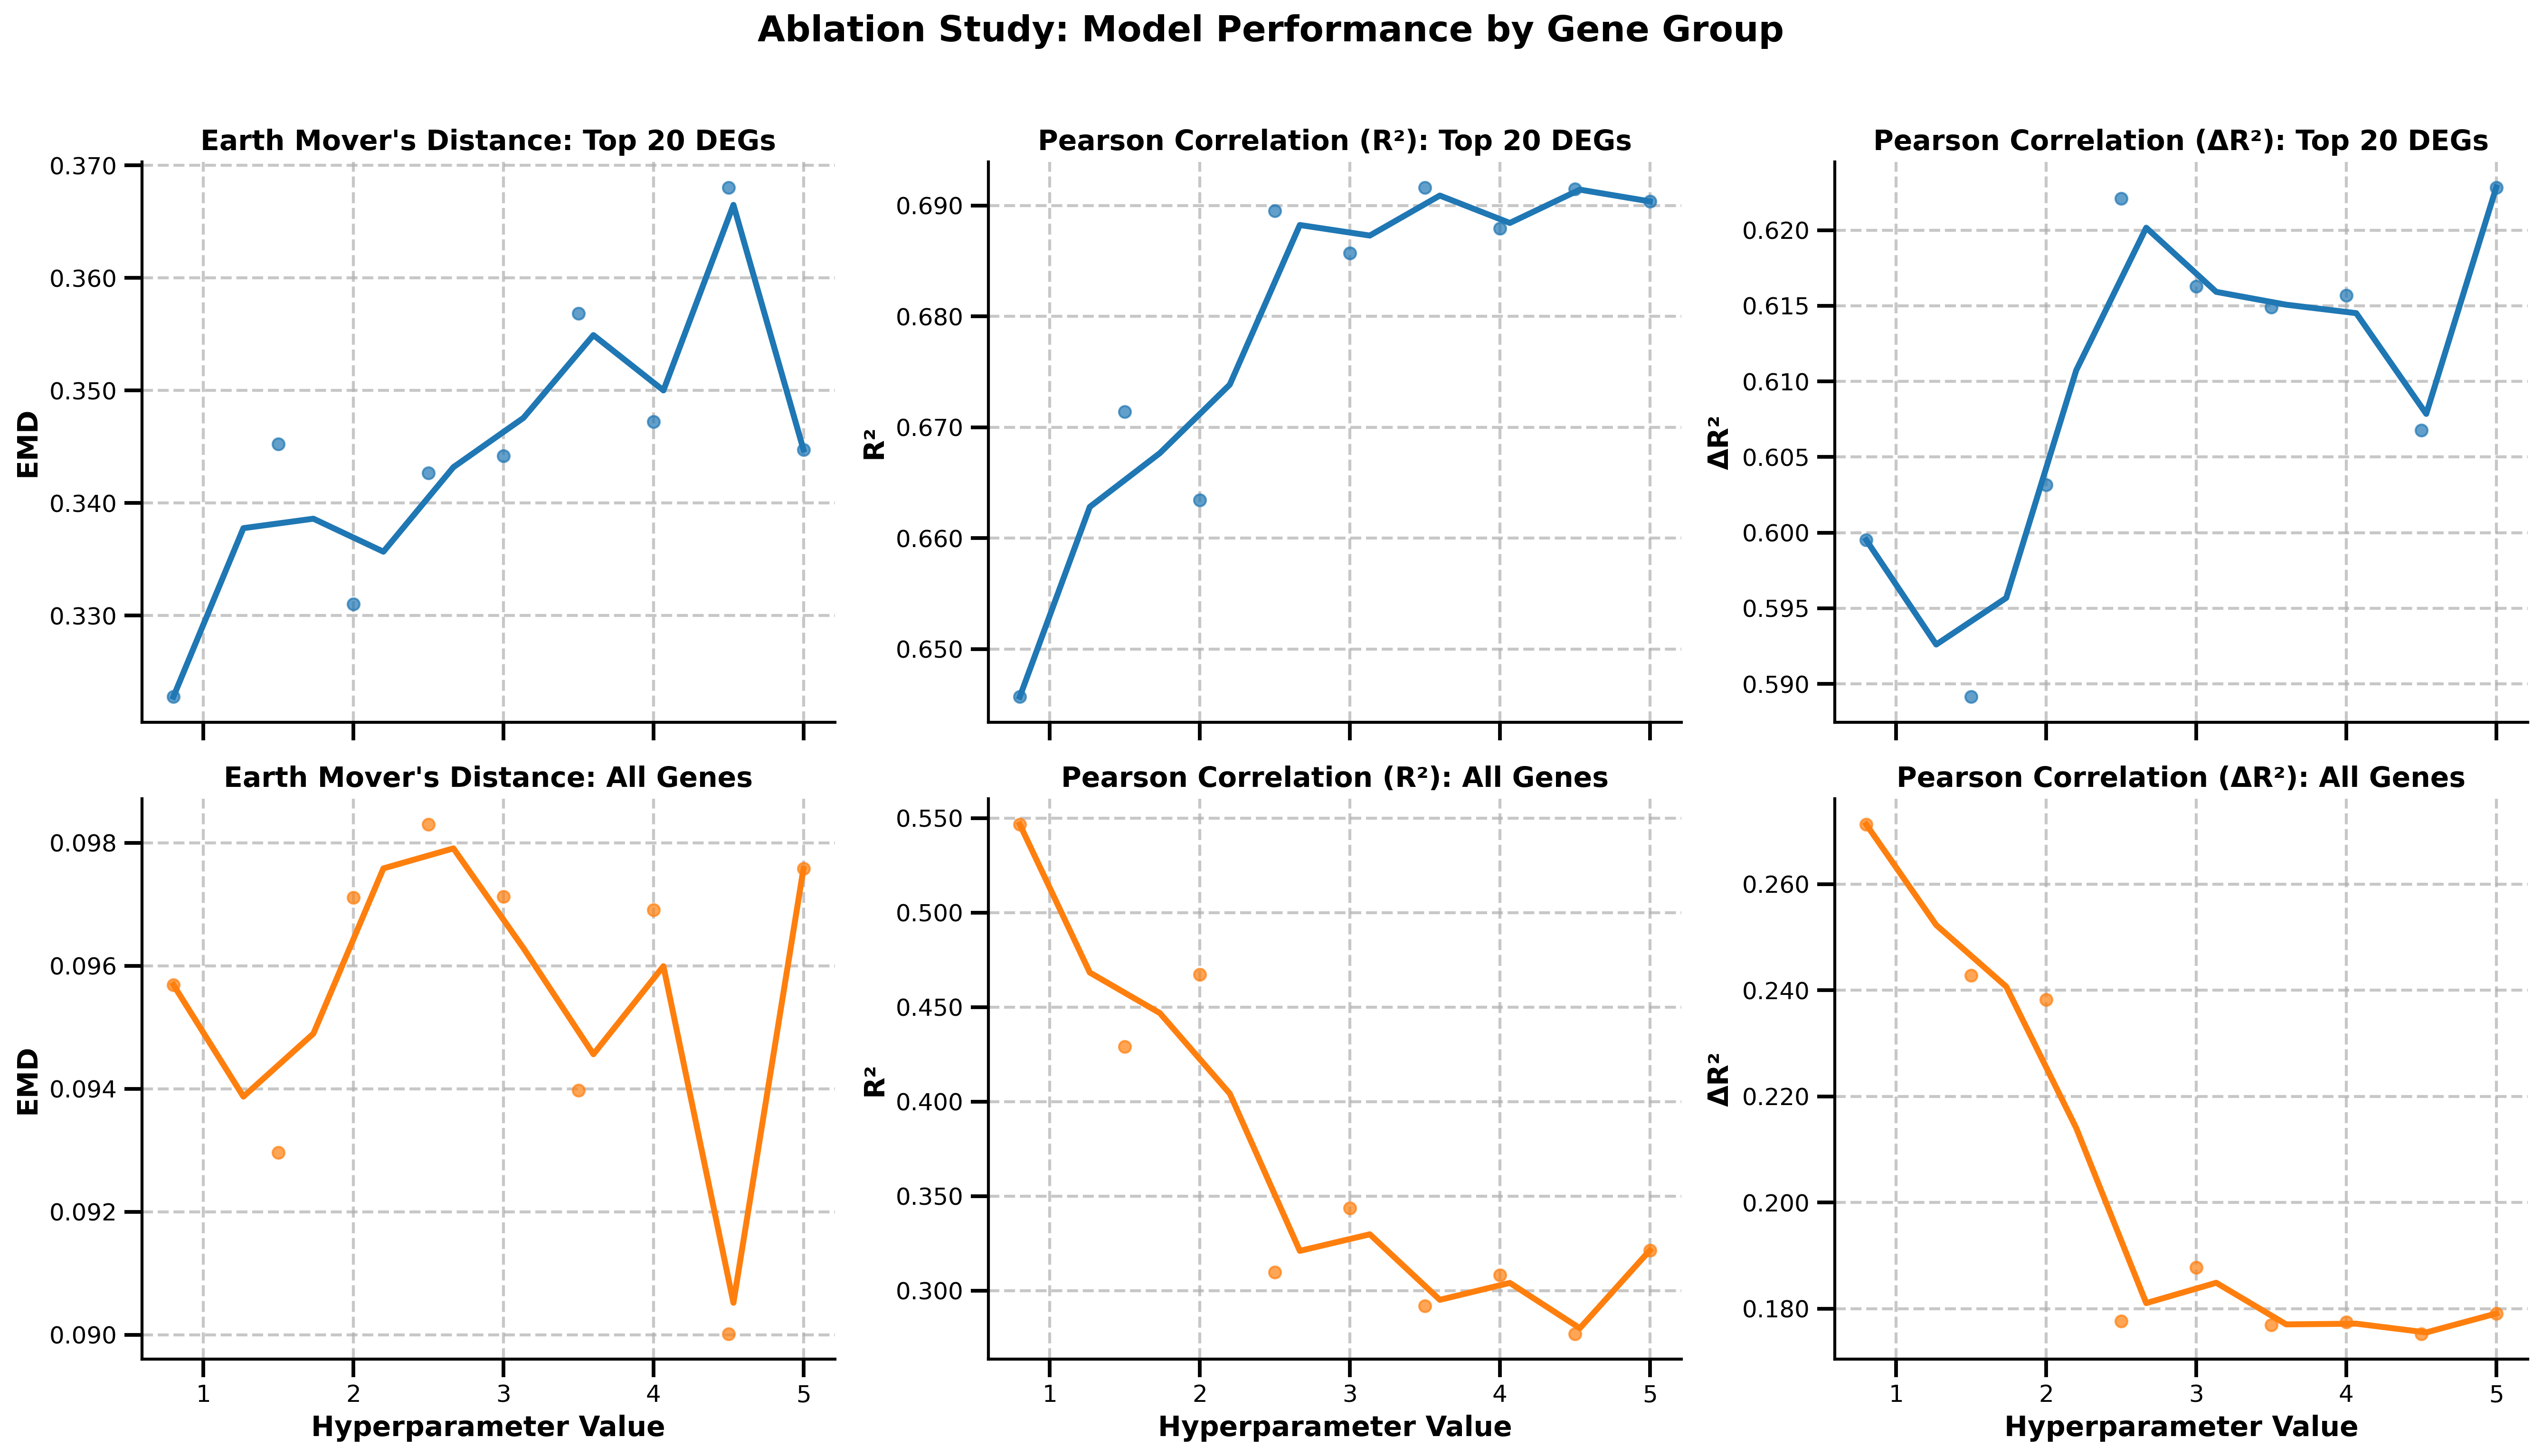

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name, max_weight=None):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    if max_weight is not None:
        hyperparam_values = [col for col in hyperparam_values if float(col) <= max_weight]
        
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name, max_weight=5)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name, max_weight=5)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()